# <center>Milestone 2</center> 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

## 1. Data Loading

In [2]:
# Paths

DATA_PATH = "data/"


# Specific paths for all datasets

MOVIES_FOLDER = DATA_PATH + "MovieSummaries/"
MOVIES_DATASET = MOVIES_FOLDER + "movie.metadata.tsv"
CHARACTERS_DATASET = MOVIES_FOLDER + "character.metadata.tsv"
CHARACTERS_NAMES_DATASET = MOVIES_FOLDER + "name.clusters.txt"
CHARACTERS_TYPES_DATASET = MOVIES_FOLDER + "tvtropes.clusters.txt"
PLOTS_DATASET = MOVIES_FOLDER + "plot_summaries.txt"
ETHNICITIES_DATASET = MOVIES_FOLDER + "ethnicities.wikidata.csv"

In [3]:
# Load movies metadata

movies = pd.read_csv(MOVIES_DATASET, sep='\t', names=['id_wiki','id_freebase','name','date',
                                                      'box_office','runtime','lang','country','genre'])
movies.head()

,id_wiki,id_freebase,name,date,box_office,runtime,lang,country,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
# Load characters metadata

characters = pd.read_csv(CHARACTERS_DATASET, sep='\t', names=['id_wiki_movie', 'id_freebase_movie', 'movie_release_date', 'character_name',
                                                      'actor_birth_date','actor_gender', 'actor_height', 'actor_ethnicity_freebase_id', 'actor_name',
                                                      'actor_age_movie_release', 'character_actor_freebase_map_id', 'character_id_freebase',
                                                      'actor_id_freebase'])
characters.head()

,id_wiki_movie,id_freebase_movie,movie_release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity_freebase_id,actor_name,actor_age_movie_release,character_actor_freebase_map_id,character_id_freebase,actor_id_freebase
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [5]:
# Load characters' names metadata

characters_names = pd.read_csv(CHARACTERS_NAMES_DATASET, sep='\t', names=['character_name', 'character_actor_freebase_map_id'])

characters_names.head()

,character_name,character_actor_freebase_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [6]:
# Load characters' types metadata

characters_types = pd.read_csv(CHARACTERS_TYPES_DATASET, sep='\t', names=['character_type', 'character_actor_freebase_map_id'])

characters_types.head()

,character_type,character_actor_freebase_map_id
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


In [7]:
# Load plot summaries' metadata

plot_summaries = pd.read_csv(PLOTS_DATASET, sep='\t', names=['id_wiki_movie', 'summary'])

plot_summaries.head()

,id_wiki_movie,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [8]:
# Load ethnicities metadata (ethnicities corresponding to freebase IDs obtained from wikidata) 

ethnicities_original = pd.read_csv(ETHNICITIES_DATASET, names=['wikidata_url', 'actor_ethnicity', 'actor_ethnicity_freebase_id'])


# Drop the wikidata_url as this will not be needed

ethnicities = ethnicities_original.drop('wikidata_url', axis = 1)

ethnicities.head()

,actor_ethnicity,actor_ethnicity_freebase_id
0,Hindu,/m/03kbr
1,European Americans,/m/02vsw1
2,Slavs,/m/0790v
3,Aymara,/m/01g3rx
4,Swiss,/m/025_0f0


In [9]:
# Merging of the ethnicities dataset into the characters dataset

characters_ethnicities = characters.merge(ethnicities, how = 'left', on = ['actor_ethnicity_freebase_id'])

characters_ethnicities.head()

,id_wiki_movie,id_freebase_movie,movie_release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity_freebase_id,actor_name,actor_age_movie_release,character_actor_freebase_map_id,character_id_freebase,actor_id_freebase,actor_ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN


## 2. General statistics about the dataset

The aim of this first section is to explore the size of the movies dataset and get a feeling for it. 

In [10]:
movies_df = movies.copy()

**2.1) Initial data processing**

In order to explore the dataset, some of the data in the movies dataset has to be preprocessed, because it is not in a format we can use. This is the case for the movie release date, the movie genre, the country of production and the movie languages.

In [11]:
# TO DO : MAYBE REMOVE NaNs HERE (because otherwise there are countries and genres 'N' and 'a'

# movie release date transformed to datetime format (we decided to only keep the years as we don't need the month and day information)
# one weird value at index 62836, date is 1010-12-02 --> could not be converted to datetime so replaced by NaT
# TO DO : DON'T FORGET TO REMOVE NaT VALUES LATER!!!!

movies_df['date'] = pd.to_datetime(movies_df['date'], errors = 'coerce', format = 'mixed').dt.year


# genres, countries and languages are given as dictionaries in the form of strings --> dictionary has to be extracted from the string
# we decided to convert the dictionary to a list, keeping only the names (not the id), to make data handling easier

movies_df['genre'] = movies_df['genre'].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')
movies_df['country'] = movies_df['country'].copy().apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')
movies_df['lang'] = movies_df['lang'].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')

**2.2) Exploring the total number of movies in the dataset.**

In [12]:
print("The total number of movies is :", movies_df.shape[0])

The total number of movies is : 81741


**2.3) Exploring the number of years covered by the dataset and the number of movies produced per year.**

In [13]:
print("Movie release years range: ", movies_df['date'].min(), "-", movies_df['date'].max())

Movie release years range:  1888.0 - 2016.0


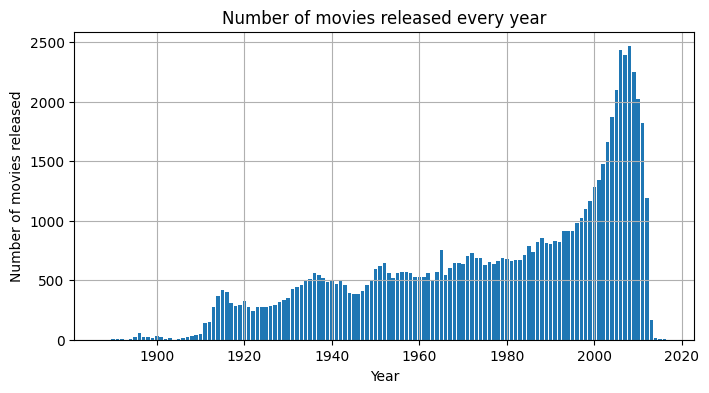

In [14]:
# calculating the number of movies per year

movies_per_year = movies_df['date'].value_counts()


# plotting the number of movies per year

plt.figure(figsize = (8, 4))
plt.bar(movies_per_year.index, movies_per_year.values)
plt.xlabel('Year')
plt.ylabel('Number of movies released')
plt.title('Number of movies released every year')
plt.grid(True)
plt.show()

**2.4) Exploring the different movie genres.** 

What are the 20 genres that are the most represented? And how many movies of each genre are there?

Since in some cases there are multiple genres for one movie, the value in the genre column is a list. In order to be able to analyze the genres separately (and not as a part of a list of genres for one given movie), we concatenated all these lists to make a big list containing all the instances of all genres.
Then we converted the list back to a pandas series, in order to drectly obtain the number of movies for each genre (using value_counts()).

In [15]:
# making one big list with all instances of all genres

genres_list = []
for genres in movies_df['genre'] : genres_list += genres


# transforming the list into a series

genres_df = pd.Series(genres_list)

# number of movies for each genre

movies_per_genre = genres_df.value_counts()


# top 20 genres with number of instances

top_20_genres = movies_per_genre[:20]

print('Top 20 most common genres, with number of movies')
top_20_genres

Top 20 most common genres, with number of movies


Drama               34007
Comedy              16349
Romance Film        10234
Black-and-white      9094
Action               8798
Thriller             8744
Short Film           8141
World cinema         7155
Crime Fiction        6948
Indie                6897
Documentary          5630
Horror               5280
Silent film          5250
Adventure            4963
Family Film          4598
N                    4588
Action/Adventure     4561
Comedy film          4362
Musical              4160
Animation            3534
Name: count, dtype: int64

**2.5) Exploring the production countries of the movies in the dataset.**

What are the top 20 countries producing most movies? And how many movies were produced in each country?

We proceded the same ways as in 2.4), first making a list, then tranforming it into a dataframe to use value_counts().

In [18]:
# making one big list with all instances of all countries

countries_list = []
for countries in movies_df['country'] : countries_list += countries


# transforming the list into a dataframe

countries_df = pd.Series(countries_list)

# number of movies for each country

movies_per_country = countries_df.value_counts()


# top 20 countries with number of movies

top_20_countries = movies_per_country[:20]

print('Top 20 most common countries, with number of movies')
top_20_countries

Top 20 most common countries, with number of movies


United States of America    34408
N                           16308
India                        8411
a                            8154
United Kingdom               7868
France                       4395
Italy                        3163
Japan                        2647
Canada                       2534
Germany                      2393
Argentina                    1468
Hong Kong                    1240
Spain                        1136
Australia                    1114
South Korea                   887
Mexico                        870
Netherlands                   840
Sweden                        657
West Germany                  647
China                         645
Name: count, dtype: int64

**2.6) Exploring the number of different languages of the movies in the dataset.**

Since there might in some cases be multiple languages for one movie, we proceded similarly to 2.4) and 2.5) by first making a list containing all instances of all languages. As we only wanted to find the total number of different languages and not the number of movies for a specific language, we then converted the list to a set.

In [19]:
# making one big list with all instances of all languages

languages_list = []
for lang in movies_df['lang'] : languages_list += lang


# number of different languages (tranforming the list into a set)

tot_languages = len(set(languages_list))

print('The total number of languages represented in the dataset is :', tot_languages)

The total number of languages represented in the dataset is : 209


**2.7) Exploring the different ethicities of the movie characters.** 

What are the different ethnicities represented in the dataset?

In [20]:
characters_ethnicities_df = characters_ethnicities.copy()

# making one big list with all instances of all countries

ethnicities_list = characters_ethnicities_df['actor_ethnicity'].to_list()

# transforming the list into a dataframe

ethnicities_df = pd.Series(ethnicities_list)

# number of character for each ethncity

characters_per_ethnicity = ethnicities_df.value_counts()


# top 20 ethnicities with number of characters

top_20_ethnicities = characters_per_ethnicity[:20]

print('Top 20 most common countries, with number of movies')
top_20_ethnicities

Top 20 most common countries, with number of movies


Indian person        16351
African Americans    10159
Jewish people        10121
English people        6165
Irish Americans       3857
Italian Americans     2956
white people          2307
White Americans       2250
Scottish American     2223
Irish people          1637
British people        1433
French                1350
Italians              1305
Tamil                 1215
Punjabis              1155
Malayali              1146
Scottish people       1028
Swedish Americans      977
German Americans       949
Swedes                 905
Name: count, dtype: int64

## 3. Test for feasability of our idea

**3.1) Defining world regions & plotting their movies over time**

We may want to define different regions of the world, grouping different countries together. We could define the following regions: 
- Europe 
- USA + Canada + Australia
- Middle East
- Asia
- Africa
- South & Central America

--> Check how many movies are contained for each subdivision over time? Do we have enough movies for each division at each timepoint to be able to draw relevant conclusions?
(Here we don't only check if our partitioning is adequate but also the general timespan we can perform our analysis on: WWI may be too early)

In [16]:
# Creating subdivisions of movies

countries_df_2 = movies.copy()
countries_df_2['date'] = pd.to_datetime(countries_df_2['date'], errors = 'coerce', format = 'mixed').dt.year


# Obtain a list of countries contained in the dataset

only_countries = countries_df_2['country'].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN').copy()
only_countries = only_countries.to_list()


# Removing all Nan's and making a onedimensional list of all countries contained in the dataset

only_countries = [x for x in only_countries if x != "NaN"]
only_countries = [item for sublist in only_countries for item in sublist]


# Creating a list with all unique countries contained in the dataset

only_countries_unique = []
for item in only_countries:
    if item not in only_countries_unique:
        only_countries_unique.append(item)

        
# Create the corresponding regions for later analysis containing all countries from the dataset

europe_countries =  ['United Kingdom', 'Croatia', 'Ukraine', 'Luxembourg', 'Belgium', 'Sweden', 'Switzerland', 'Greece', 'Ireland',  'Iceland', 'Poland', 'Italy', 'Denmark',  'Scotland', 'Finland', 'Albania', 'Portugal', 'Northern Ireland', 'Austria',  'Netherlands', 'Monaco', 'Spain',  'England',  'German Democratic Republic', 'France', 'Nazi Germany', 'West Germany',  'Germany', 'Weimar Republic', 'Kingdom of Italy', 'Kingdom of Great Britain', 'Isle of Man', 'Lithuania', 'Malta', 'Czech Republic',  'Czechoslovakia', 'Slovakia', 'Romania', 'Norway', 'Serbia', 'Slovenia', 'Bulgaria', 'Slovak Republic', 'Ukrainian SSR',  'Ukranian SSR',  'Estonia',  'Soviet occupation zone', 'Bosnia and Herzegovina', 'Socialist Federal Republic of Yugoslavia', 'Yugoslavia', 'Wales', 'Hungary', 'Federal Republic of Yugoslavia',  'Serbia and Montenegro', 'Republic of Macedonia', 'Montenegro', 'Cyprus', 'Crime']
middle_east_countries = ['Lebanon', 'Iran', 'United Arab Emirates', 'Iraq', 'Turkey', 'Iraqi Kurdistan', 'Jordan', 'Mandatory Palestine', 'Palestinian territories', 'Palestinian Territories', 'Armenia', 'Georgia', 'Kuwait', 'Georgian SSR', 'Israel', 'Turkmenistan', 'Qatar', 'Bahrain', 'Azerbaijan']
asia_countries = ['Hong Kong', 'Nepal', 'Indonesia', 'China',  'Taiwan', 'Cambodia', 'Vietnam', 'Sri Lanka', 'Singapore', 'Thailand', 'Mongolia', 'Korea', 'India', 'Malaysia', 'South Korea', 'Philippines', 'Republic of China', 'Japan',  'Soviet Union', 'Bangladesh', 'Russia', 'Pakistan', 'Uzbekistan', 'Afghanistan', 'Macau', 'Uzbek SSR', 'Bhutan', 'Burma']
africa_countries = ['Guinea', 'Cameroon', 'Democratic Republic of the Congo', 'Tunisia', 'Congo', 'Ethiopia', 'Nigeria', 'Libya', 'Zimbabwe', 'Morocco',  'Mali', 'Egypt', 'Burkina Faso', 'Senegal', 'Kenya', 'South Africa', 'Algeria', 'Zambia', 'Guinea-Bissau']
south_central_america_countries =  ['Mexico', 'Colombia', 'Uruguay', 'Puerto Rico',  'Costa Rica', 'Chile', 'Venezuela', 'Peru', 'Bolivia', 'Brazil', 'Cuba', 'Panama', 'Argentina', 'Haiti', 'Bahamas', 'Jamaica', 'Aruba']
other_countries = ['United States of America', 'Canada', 'Australia', 'New Zealand']
outlier_countries = [ 'German Language', 'Malayalam Language'] 


# Check that all countries in the dataset are contained in a certain region

all_countries = europe_countries + middle_east_countries + asia_countries + africa_countries + south_central_america_countries + other_countries + outlier_countries
print(len(only_countries_unique))
print(len(all_countries))

147
147


**Important Observations:**
- A movie can be produced by multiple countries at the same time
- In the entries of some countries, there are typos or different syntax which is why these countries are not considered identical. To avoid any effects this can have, all manners of which the country was written was included in the grouping. Examples of this are:
    - “Ukrainian SSR” vs “Ukranian SSR”
    - “Socialist Federal Republic of Yugoslavia” vs “Yugoslavia” vs “Federal Republic of Yugoslavia”
    - “Palestinian territories” vs “Palestinian Territories”
- There are a few entries which do not correspond to countries. These were grouped into the list "outlier_countries" and will not be used for country analysis, as we cannot be completely sure what countries produced them. Examples of this are:
    - “German Language”
    - “Malayalam Language”

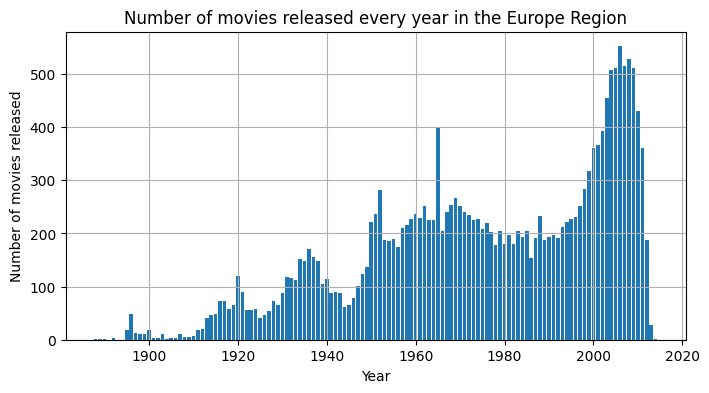

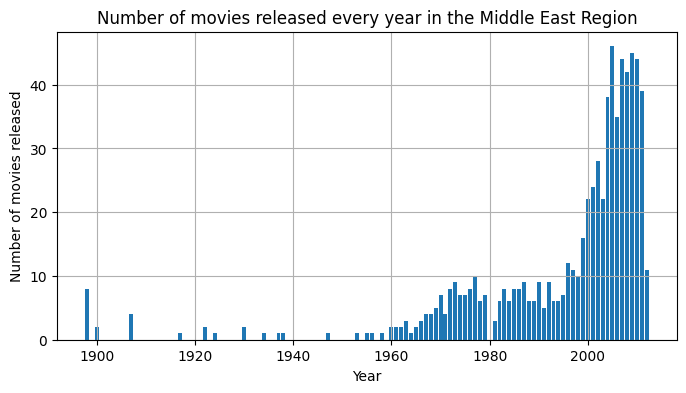

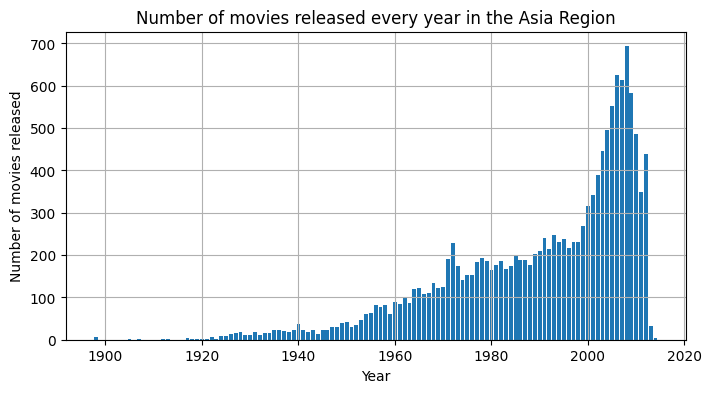

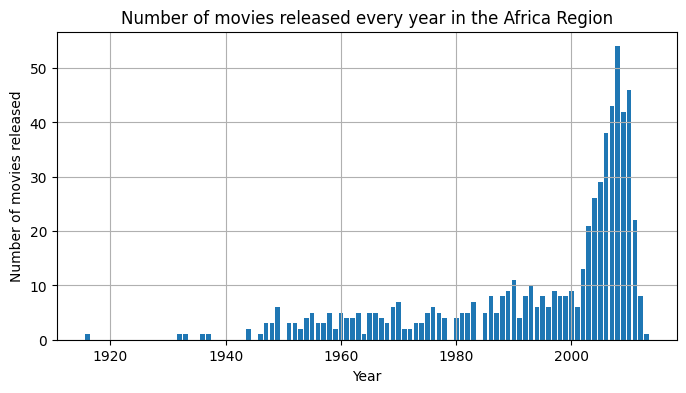

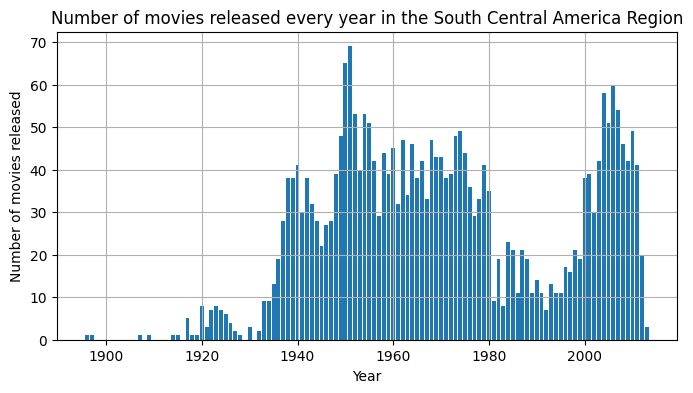

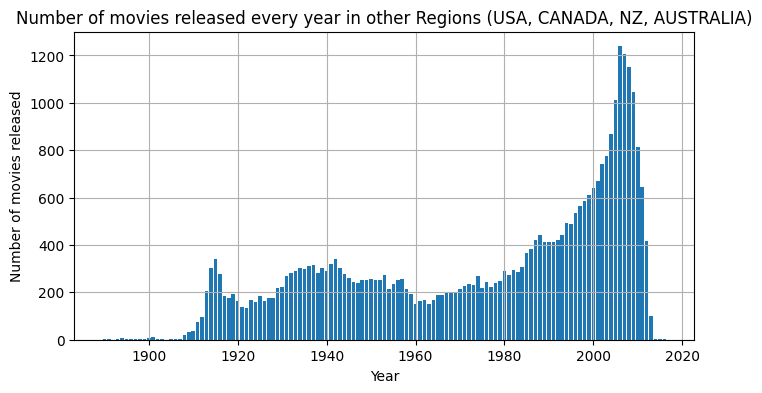

In [17]:
# Check how many movies are contained for each subdivision over time


# Check for Region Europe

filtered_europe_movies = countries_df_2[countries_df_2['country'].apply(lambda x: any(item in x for item in europe_countries))]
movies_per_year_europe = filtered_europe_movies['date'].value_counts()

plt.figure(figsize = (8, 4))
plt.bar(movies_per_year_europe.index, movies_per_year_europe.values)
plt.xlabel('Year')
plt.ylabel('Number of movies released')
plt.title('Number of movies released every year in the Europe Region')
plt.grid(True)
plt.show()


# Check for Region Middle East

filtered_middle_east_movies = countries_df_2[countries_df_2['country'].apply(lambda x: any(item in x for item in middle_east_countries))]
movies_per_year_middle_east = filtered_middle_east_movies['date'].value_counts()

plt.figure(figsize = (8, 4))
plt.bar(movies_per_year_middle_east.index, movies_per_year_middle_east.values)
plt.xlabel('Year')
plt.ylabel('Number of movies released')
plt.title('Number of movies released every year in the Middle East Region')
plt.grid(True)
plt.show()


# Check for Region Asia

filtered_asia_movies = countries_df_2[countries_df_2['country'].apply(lambda x: any(item in x for item in asia_countries))]
movies_per_year_asia = filtered_asia_movies['date'].value_counts()

plt.figure(figsize = (8, 4))
plt.bar(movies_per_year_asia.index, movies_per_year_asia.values)
plt.xlabel('Year')
plt.ylabel('Number of movies released')
plt.title('Number of movies released every year in the Asia Region')
plt.grid(True)
plt.show()


# Check for Region Africa

filtered_africa_movies = countries_df_2[countries_df_2['country'].apply(lambda x: any(item in x for item in africa_countries))]
movies_per_year_africa = filtered_africa_movies['date'].value_counts()

plt.figure(figsize = (8, 4))
plt.bar(movies_per_year_africa.index, movies_per_year_africa.values)
plt.xlabel('Year')
plt.ylabel('Number of movies released')
plt.title('Number of movies released every year in the Africa Region')
plt.grid(True)
plt.show()


# Check for region South Central America

filtered_south_central_america_movies = countries_df_2[countries_df_2['country'].apply(lambda x: any(item in x for item in south_central_america_countries))]
movies_per_year_south_central_america = filtered_south_central_america_movies['date'].value_counts()

plt.figure(figsize = (8, 4))
plt.bar(movies_per_year_south_central_america.index, movies_per_year_south_central_america.values)
plt.xlabel('Year')
plt.ylabel('Number of movies released')
plt.title('Number of movies released every year in the South Central America Region')
plt.grid(True)
plt.show()


# Check for region Other (includes USA, Australia, New Zealand, Canada)

filtered_other_movies = countries_df_2[countries_df_2['country'].apply(lambda x: any(item in x for item in other_countries))]
movies_per_year_other = filtered_other_movies['date'].value_counts()

plt.figure(figsize = (8, 4))
plt.bar(movies_per_year_other.index, movies_per_year_other.values)
plt.xlabel('Year')
plt.ylabel('Number of movies released')
plt.title('Number of movies released every year in other Regions (USA, CANADA, NZ, AUSTRALIA)')
plt.grid(True)
plt.show()

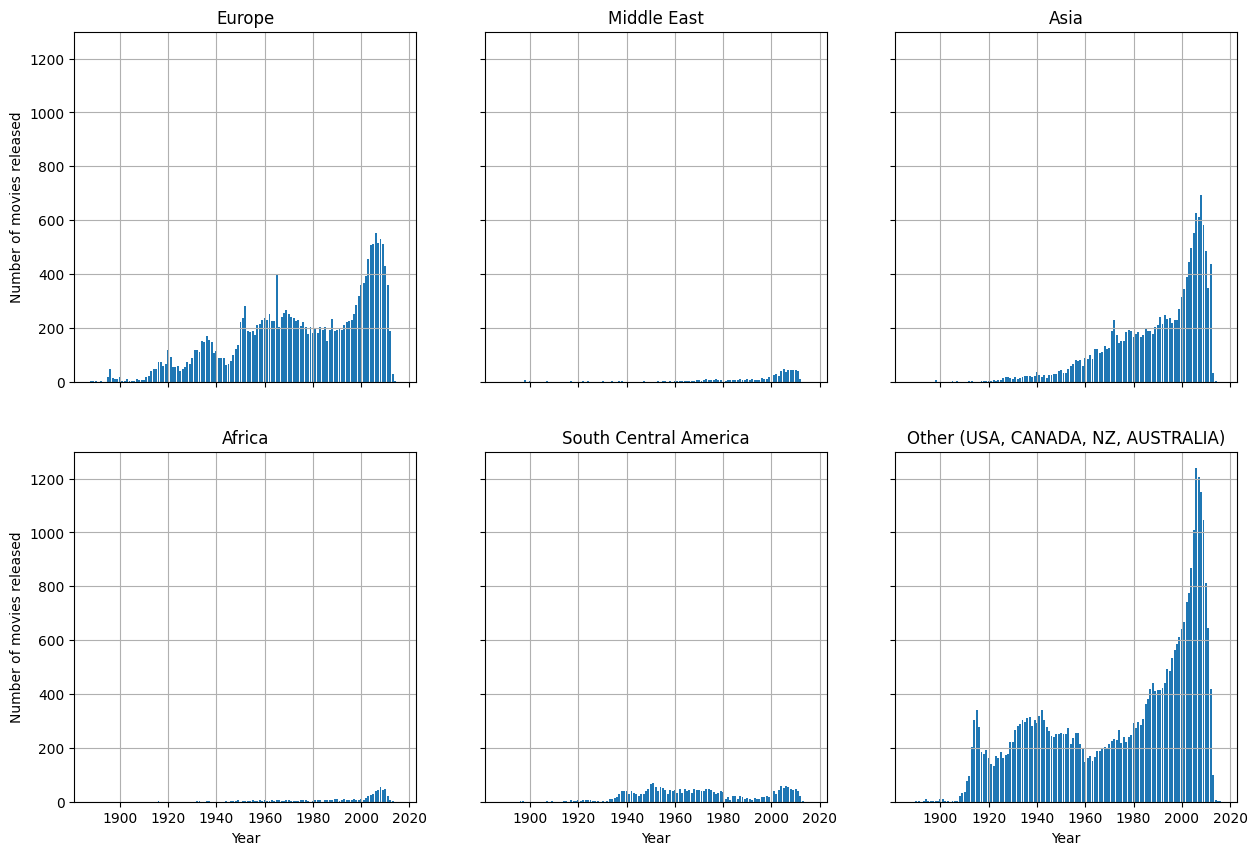

In [18]:
# Check how many movies are contained for each subdivision over time, constructing subplots with the same y-axis

fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

# Check for Region Europe
axs[0, 0].bar(movies_per_year_europe.index, movies_per_year_europe.values)
axs[0, 0].set_title('Europe')

# Check for Region Middle East
axs[0, 1].bar(movies_per_year_middle_east.index, movies_per_year_middle_east.values)
axs[0, 1].set_title('Middle East')

# Check for Region Asia
axs[0, 2].bar(movies_per_year_asia.index, movies_per_year_asia.values)
axs[0, 2].set_title('Asia')

# Check for Region Africa
axs[1, 0].bar(movies_per_year_africa.index, movies_per_year_africa.values)
axs[1, 0].set_title('Africa')

# Check for region South Central America
axs[1, 1].bar(movies_per_year_south_central_america.index, movies_per_year_south_central_america.values)
axs[1, 1].set_title('South Central America')

# Check for region Other (includes USA, Australia, New Zealand, Canada)
axs[1, 2].bar(movies_per_year_other.index, movies_per_year_other.values)
axs[1, 2].set_title('Other (USA, CANADA, NZ, AUSTRALIA)')

for ax in axs.flat:
    ax.set(xlabel='Year', ylabel='Number of movies released')
    ax.grid(True)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()

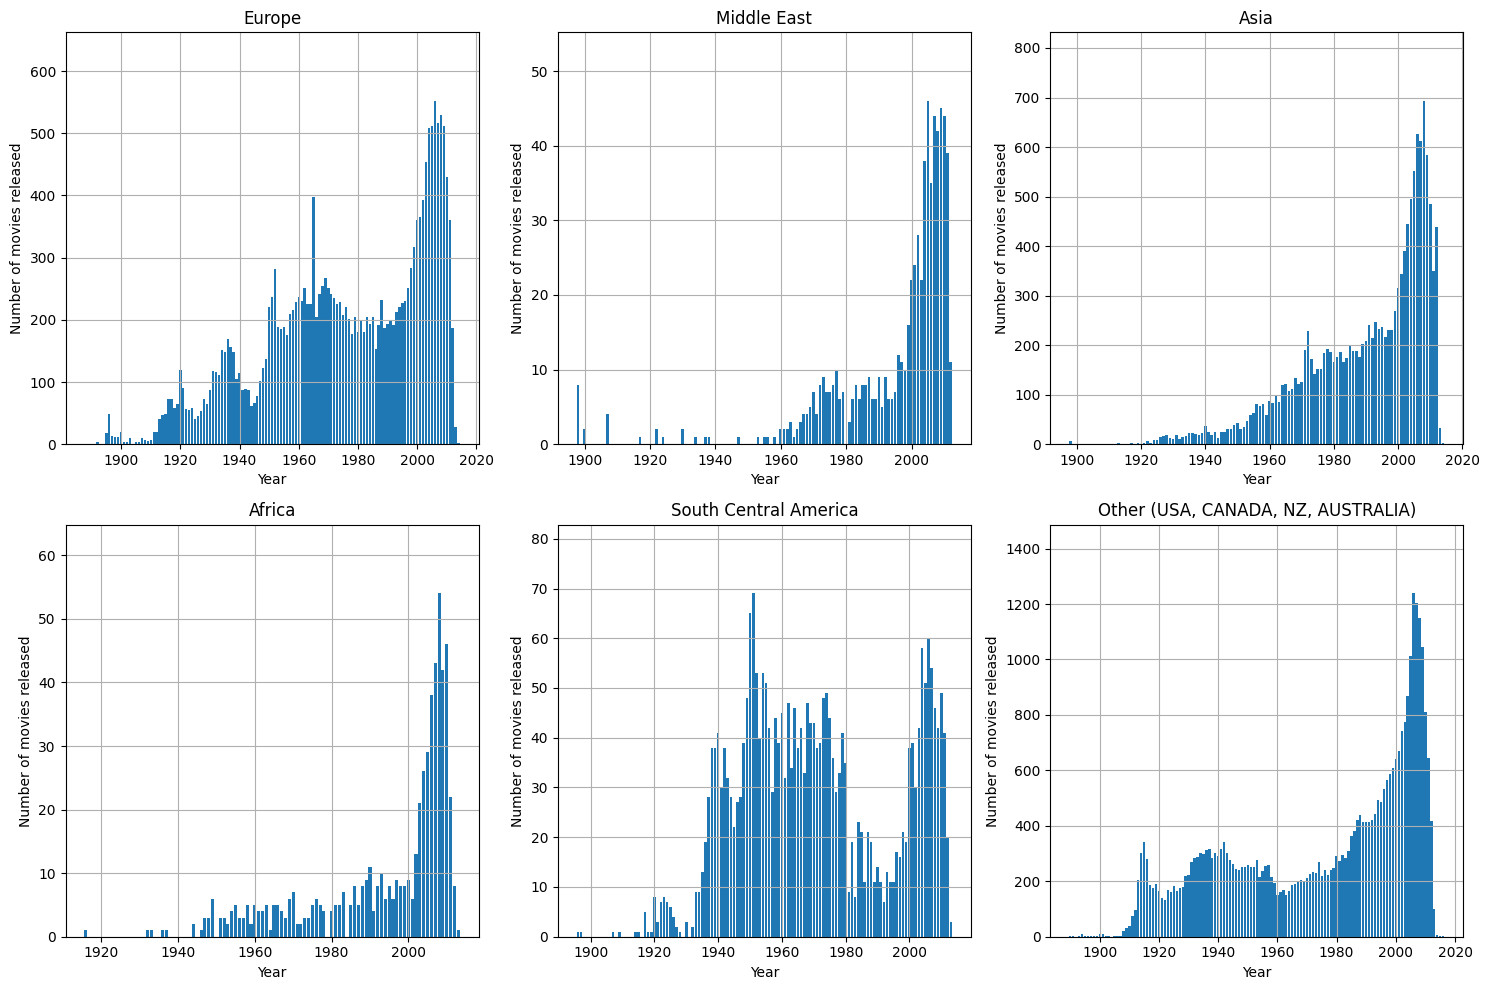

In [19]:
# Check how many movies are contained for each subdivision over time, constructing subplots with individual y-axes

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Check for Region Europe
axs[0, 0].bar(movies_per_year_europe.index, movies_per_year_europe.values)
axs[0, 0].set_title('Europe')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Number of movies released')
axs[0, 0].set_ylim([0, movies_per_year_europe.values.max() * 1.2])  # Adjust the multiplier as needed
axs[0, 0].grid(True)

# Check for Region Middle East
axs[0, 1].bar(movies_per_year_middle_east.index, movies_per_year_middle_east.values)
axs[0, 1].set_title('Middle East')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Number of movies released')
axs[0, 1].set_ylim([0, movies_per_year_middle_east.values.max() * 1.2])  # Adjust the multiplier as needed
axs[0, 1].grid(True)

# Check for Region Asia
axs[0, 2].bar(movies_per_year_asia.index, movies_per_year_asia.values)
axs[0, 2].set_title('Asia')
axs[0, 2].set_xlabel('Year')
axs[0, 2].set_ylabel('Number of movies released')
axs[0, 2].set_ylim([0, movies_per_year_asia.values.max() * 1.2])  # Adjust the multiplier as needed
axs[0, 2].grid(True)

# Check for Region Africa
axs[1, 0].bar(movies_per_year_africa.index, movies_per_year_africa.values)
axs[1, 0].set_title('Africa')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Number of movies released')
axs[1, 0].set_ylim([0, movies_per_year_africa.values.max() * 1.2])  # Adjust the multiplier as needed
axs[1, 0].grid(True)

# Check for region South Central America
axs[1, 1].bar(movies_per_year_south_central_america.index, movies_per_year_south_central_america.values)
axs[1, 1].set_title('South Central America')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Number of movies released')
axs[1, 1].set_ylim([0, movies_per_year_south_central_america.values.max() * 1.2])  # Adjust the multiplier as needed
axs[1, 1].grid(True)

# Check for region Other (includes USA, Australia, New Zealand, Canada)
axs[1, 2].bar(movies_per_year_other.index, movies_per_year_other.values)
axs[1, 2].set_title('Other (USA, CANADA, NZ, AUSTRALIA)')
axs[1, 2].set_xlabel('Year')
axs[1, 2].set_ylabel('Number of movies released')
axs[1, 2].set_ylim([0, movies_per_year_other.values.max() * 1.2])  # Adjust the multiplier as needed
axs[1, 2].grid(True)

plt.tight_layout()
plt.show()

**3.2) Number and percentage of NAN values contained in our datasets, specifically for some characteristics that are important for us**

As important data for further analysis, we consider:
- Actor DOB 
- Actor Gender
- Actor Height 
- Actor Ethnicity
- Actor Age at movie release
- Movie Release Date
- Movie Box Office Revenue
- Movie Languages
- Movie Countries
- Movie Genres
- Do all movies have a plot summary? --> to answer to this we must merge some data and the see if NAN values emerge for some movies

Interesting questions to answer:

* Analysis of NANs and evaluation if we still have enough movie sets to analyse, should we have to cross those containing important NANs out. 

Charlotte: we have anough movie sets to analyse I believe, however for certain features since we have a lot of NANs, we should be attentive to our conclusions and their statistically significance. It could be a good idea to merge some columns of dataframes to perform some analysis but crossing those containing a lot of NANs values does not appear to ma as a good idea. We could still use them for a few analysis for the data they contain.

* Evaluate if we should eliminate movie from whole analysis, as soon as it does not contain one of the important characteristics or if we should only remove it for the specific analysis this characteristic is used for.

Charlotte: for me, we should not eliminate a movie from whole analysis if it does not contain one of the important characteristics because as one can observe below, for some features we have a lot of NANs values. ==> we should maybe indeed remove it for the specific analysis of a particular feature.

In [20]:
characters_df = characters.copy()


# Computing number of NAN and percentage of NAN in the actors' date of birth column of the characters dataset

actors_DOB_NAN_count = (characters_df['actor_birth_date'].isna() == True).sum()
missing_actors_DOB_percentage = characters['actor_birth_date'].isna().mean() * 100
print(f"There are {actors_DOB_NAN_count} NAN values in the actors' birth date column of the characters dataset.")
print(f"This corresponds of {missing_actors_DOB_percentage:.2f} % of the actors' birth dates total data. \n")


# Computing number of NAN and percentage of NAN in the actors' gender column of the characters dataframe

actors_genders_NAN_count = (characters_df['actor_gender'].isna() == True).sum()
missing_actors_genders_percentage = characters_df['actor_gender'].isna().mean() * 100
print(f"There are {actors_genders_NAN_count} NAN values in the actors' gender column of the characters dataset.")
print(f"This corresponds to a percentage of {missing_actors_genders_percentage:.2f} % of the actors' genders total data. \n")


# Computing number of NAN and percentage of NAN in the actors' gender column of the characters dataframe

actors_heights_NAN_count = (characters_df['actor_height'].isna() == True).sum()
missing_actors_heights_percentage = characters_df['actor_height'].isna().mean() * 100
print(f"There are {actors_heights_NAN_count} NAN values in the actors' height column of the characters dataset.")
print(f"This corresponds to a percentage of {missing_actors_heights_percentage:.2f} % of the actors' heights total data. \n")


# Computing number of NAN and percentage of NAN in the actors' ethnicity column of the characters dataframe

actors_ethnicities_NAN_count = (characters_df['actor_ethnicity'].isna() == True).sum()
missing_actors_ethnicities_percentage = characters_df['actor_ethnicity'].isna().mean() * 100
print(f"There are {actors_ethnicities_NAN_count} NAN values in the actors' ethnicity column of the characters dataset.")
print(f"This corresponds to a percentage of {missing_actors_ethnicities_percentage:.2f} % of the actors' ethinicities total data. \n")


# Computing number of NAN and percentage of NAN in the actors' age at movie release column of the characters dataframe

actors_age_movie_release_NAN_count = (characters_df['actor_age_movie_release'].isna() == True).sum()
missing_actors_age_movie_release_percentage = characters_df['actor_age_movie_release'].isna().mean() * 100
print(f"There are {actors_age_movie_release_NAN_count} NAN values in the actors' age at movie release column of the characters dataset.")
print(f"This corresponds to a percentage of {missing_actors_age_movie_release_percentage:.2f} % of the actors' age at movie release total data. \n")


# Computing number of NAN and percentage of NAN in the movies' release date column of the characters dataframe

movie_release_date_NAN_count = (characters_df['movie_release_date'].isna() == True).sum()
missing_movie_release_date_percentage = characters_df['movie_release_date'].isna().mean() * 100
print(f"There are {movie_release_date_NAN_count} NAN values in the movies' release date column of the characters dataset.")
print(f"This corresponds to a percentage of {missing_movie_release_date_percentage:.2f} % of the movies' release date total data. \n")


# Computing number of NAN and percentage of NAN in the movies' box office column of the characters dataframe

movie_box_office_NAN_count = (movies_df['box_office'].isna() == True).sum()
missing_movie_box_office_percentage = movies_df['box_office'].isna().mean() * 100
print(f"There are {movie_box_office_NAN_count} NAN values in the movies' box office column of the characters dataset.")
print(f"This corresponds to a percentage of {missing_movie_box_office_percentage:.2f} % of the movies' box office total data. \n")


# Computing number of NAN and percentage of NAN in the movies' language column of the characters dataframe

movie_lang_NAN_count = (movies_df['lang'].isna() == True).sum()
missing_movie_lang_percentage = movies_df['lang'].isna().mean() * 100
print(f"There are {movie_lang_NAN_count} NAN values in the movies' language column of the characters dataset.")
print(f"This corresponds to a percentage of {missing_movie_lang_percentage:.2f} % of the movies' languages total data. \n")


# Computing number of NAN and percentage of NAN in the movies' country column of the characters dataframe

movie_countries_NAN_count = (movies_df['country'].isna() == True).sum()
missing_movie_countries_percentage = movies_df['country'].isna().mean() * 100
print(f"There are {movie_countries_NAN_count} NAN values in the movies' country column of the characters dataset.")
print(f"This corresponds to a percentage of {missing_movie_countries_percentage:.2f} % of the movies' countries total data. \n")


# Computing number of NAN and percentage of NAN in the movies' genre column of the characters dataframe

movie_genres_NAN_count = (movies_df['genre'].isna() == True).sum()
missing_movie_genres_percentage = movies_df['genre'].isna().mean() * 100
print(f"There are {movie_genres_NAN_count} NAN values in the movies' genre column of the characters dataset.")
print(f"This corresponds to a percentage of {missing_movie_genres_percentage:.2f} % of the movies' genres total data. \n")

There are 106145 NAN values in the actors' birth date column of the characters dataset.
This corresponds of 23.55 % of the actors' birth dates total data. 

There are 45609 NAN values in the actors' gender column of the characters dataset.
This corresponds to a percentage of 10.12 % of the actors' genders total data. 

There are 295845 NAN values in the actors' height column of the characters dataset.
This corresponds to a percentage of 65.65 % of the actors' heights total data. 

There are 344611 NAN values in the actors' ethnicity column of the characters dataset.
This corresponds to a percentage of 76.47 % of the actors' ethinicities total data. 

There are 158113 NAN values in the actors' age at movie release column of the characters dataset.
This corresponds to a percentage of 35.08 % of the actors' age at movie release total data. 

There are 9995 NAN values in the movies' release date column of the characters dataset.
This corresponds to a percentage of 2.22 % of the movies' rel

**3.3) Word cloud algorithm**

The algorithm below creates a words' list of all words present in movies' summaries with their associated frequencies of appearence in all summaries. Here, for now, we only print the top 50 most used words in summaries.

**ATTENTION:**
Pour run le code pour cette partie, vous devez d'abord run les deux commandes commentées dans la cellule juste en-dessous une fois et ensuite vous pouvez les commenter de nouveau.

In [21]:
#nltk.download('punkt')
#nltk.download('stopwords')

In [22]:
from collections import Counter
import nltk
from nltk import punkt
from nltk.corpus import stopwords

In [23]:
plot_summaries_df = plot_summaries.copy()

# Pre-processing summaries' text data

summaries_text = ' '.join(plot_summaries_df['summary']) # Combine all text data into a single string
summaries_words = nltk.word_tokenize(summaries_text.lower()) # Convert to lowercase and tokenize
words_freq = Counter(summaries_words) # Count word frequencies


# Remove common stop words and punctuations

stop_words = set(stopwords.words('english'))
word_freq = {word: freq for word, freq in words_freq.items() if word not in stop_words and word.isalpha()}


# Sort words by frequency in descending order

sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)


# Extract the 50 most frequently appearing words in plots' summaries

top_50_word = sorted_word_freq[:49]
top_50_word_list = [word for word, _ in top_50_word]

print(top_50_word_list)

['one', 'back', 'two', 'film', 'father', 'man', 'tells', 'time', 'life', 'love', 'new', 'get', 'home', 'family', 'also', 'find', 'house', 'however', 'finds', 'later', 'mother', 'goes', 'go', 'takes', 'police', 'day', 'away', 'young', 'take', 'wife', 'first', 'gets', 'tries', 'help', 'son', 'night', 'friend', 'story', 'begins', 'way', 'death', 'becomes', 'woman', 'money', 'killed', 'next', 'friends', 'make', 'men']


**3.4) Characters Features Analysis**

Interesting questions:
* How are we able to extract the "villain" and the "main character" from a movie plot? 
* How can we get their typical characteristics? 
* Can we test the principle of this for a specific movie?

The code below allows to detect from a movie summary the movies' characters, the adjectives that characterize them and the verbs associated to them in the text. Here, a random movie summary has been chosen just to show that the code works.

**ATTENTION:** 

Pour run le code suivant, vous devez d'abord installer un environnement virtuel qui vous permettra d'intégrer le module SpaCy et de load la langue anglaise, ce qui permet de faire des analyses de textes non-biaisées et rapides.

Pour cela, vous devez effectuer les commandes suivantes dans votre terminal sur Jupyter Notebook:
```
my_venvs_create spacy_env
my_venvs_activate spacy_env
pip install spacy
python -m spacy download en_core_web_sm
my_kernels_create py3_spacy "Py3 Spacy"
my_venvs_deactivate
```
Et après, pour run votre notebook, choisissez comme kernel celui que vous venez de créer "Py3 Spacy".

In [24]:
import spacy

In [25]:
# Load the English language model

nlp = spacy.load("en_core_web_sm")


# Sample a movie summary

movie_summary_example = plot_summaries['summary'][1]


# Process the movie summary

doc = nlp(movie_summary_example)


# Create two dictionaries to store characters, their related adjectives and verbs

characters_adjectives = {}
characters_verbs = {}


# Extract character's names (assuming it's mentioned as a proper noun)

characters_names = []
for entity in doc.ents:
    if entity.label_ == "PERSON":
        characters_names.append(entity.text)


# Dropping characters' duplicates

characters_names_unique = []
for item in characters_names:
    if item not in characters_names_unique:
        characters_names_unique.append(item)

In [26]:
# Extract adjectives related to each character in the movie's summary

adjectives = []
for character in characters_names_unique:
    for token in doc: 
        if token.pos_ == "ADJ" and token.head.text == character:
            adjectives.append(token.text)
   
        if len(adjectives) == 0 :
            characters_adjectives[character] = ['No related adjectives.']
        else:
            characters_adjectives[character] = adjectives
    
    adjectives = []

    
# Print the results

print("THE CHARACTERS AND THEIR RELATED ADJECTIVES: \n")
for character_name, adjectives in characters_adjectives.items():
    print(f"{character_name}: {', '.join(adjectives)} \n")

THE CHARACTERS AND THEIR RELATED ADJECTIVES: 

Katniss: tormenting 

Peeta Mellark: No related adjectives. 

baker: No related adjectives. 

Peeta: No related adjectives. 

Haymitch Abernathy: No related adjectives. 

Haymitch: No related adjectives. 

Rue: No related adjectives. 

Snow: No related adjectives. 

Seneca Crane: No related adjectives. 

Thresh: No related adjectives. 

Cato: No related adjectives. 

Crane: No related adjectives. 



In [27]:
# Extract verbs related to each character in the movie's summary

verbs = []
for character in characters_names_unique:
    for sentence in doc.sents:
        for token in sentence: 
            if token.pos_ == "VERB" and character in [word.text for word in sentence]:
                verbs.append(token.text)
            if len(verbs) == 0:
                characters_verbs[character] = ['No related verbs.']
            else:
                characters_verbs[character] = verbs
    verbs = []


# Print the results

print("THE CHARACTERS AND THEIR RELATED VERBS: \n")
for character_name, verbs in characters_verbs.items():
    print(f"{character_name}: {', '.join(verbs)} \n")

THE CHARACTERS AND THEIR RELATED VERBS: 

Katniss: take, gave, starving, taken, accompanied, reveals, televised, begin, killed, survives, ignoring, run, tempting, strewn, called, find, corner, drops, warned, run, cares, recovers, has, draw, destroys, setting, planted, runs, hears, calling, throws, dodges, causing, stab, shoots, presented, crossed, convince, make, avoid, inciting, hearing, finds, promises, go, falls, heads, kills, overhearing, killing, spares, kill, force, flee, encounter, wounds, hurls, shoots, spare, prolonged, allowing, revoked, tells, shoot, warns, made 

Peeta Mellark: No related verbs. 

baker: gave, starving 

Peeta: gave, starving, taken, accompanied, reveals, discovers, meant, said, forms, warned, run, presented, crossed, convince, make, avoid, inciting, hearing, finds, begs, risk, getting, works, keeping, dies, eating, stole, knew, kill, force, flee, encounter, wounds, hurls, allowing, revoked, tells, shoot, locked, considers 

Haymitch Abernathy: No related v

**3.5) Presence of outlier characteristics**

We need to analyze each of the important characteristics for us to see if there are other values apart from NaN's that we cannot use for our data analysis. Ex: "German Language" in column "Country".
The important characteristics are:
- Actor DOB
- Actor Gender
- Actor Height
- Actor Ethnicity
- Actor Age at movie release
- Movie Release Date
- Movie Box Office Revenue
- Movie Languages
- Movie Countries
- Movie Genres

**3.5.1) Outlier Characteristics of Actor DOB**

In [28]:
# Testing for outliers contained in the "actor_birth_date" column

from datetime import datetime
import re

outlier_dates = [date for date in characters['actor_birth_date'] if not re.match(r'\d{4}-\d{2}-\d{2}', str(date))]
outlier_dates_unique = list(set(outlier_dates))

print(outlier_dates_unique)


# Check for dates out of our timerange

impossible_dates = []

for date in outlier_dates:
    if isinstance(date, str): # Don't take into consideration nan's
        year_string = date.split('-')[0] # Extract the 'year' from the date
        if (int(year_string) > 2016 or int(year_string) < 1800):  
            impossible_dates.append(date)

        
print(impossible_dates)

['1972', '1955-12', '1931-12', '1920-03', '1960-06', '1945-04', '1882-08', '1961', '1955-01', '1940-10', '1962-05', '1951-04', '1979-04', '1979', '1906', '1994-06', '1894-10', '1958-12', '1914', '1889', '1874', '1929-12', '2002-02', '1901', '1964-10', '1922-09', '2000-08', '1903', '1858', '1935-05', '1936', '1952-10', '1974-01', '2000', '1866-06', '0183', '1918', '1954', '1997', '1985', '1888', '1926-08', '1978', '1854', '1951', '1959-04', '1968-04', '2004', '1881-06', '1976-12', '1943-06', '1890', '1951-02', '1999-05', '2005', '1965-09', '1936-10', '1966-09', '1956', '1849', '1989', '1940-01', '1930', '1982-03', '1968-08', '1913', '1947-10', '1891', '1968-12', '1943-10', '1968-10', '1965-08', '1949', '1895', '1971', '1974-07', '1862', '1884', '1998-12', '1939-02', '1947', '1986', '1965', '1968', '1922', '1961-10', '1998-09', '1924', '1897-06', '1860', '1980', '1892', '1963', '1959-03', '1979-10', '1938-01', '1964-11', '1853', '1939', '1882', '1990-06', '1916', '1986-10', '1966-06', '1

Important observations of the column 'actor_birth_date':
- Contains NaN's
- Contains dates of different detail:
    - YYYY-MM-DD
    - YYYY-MM
    - YYYY
- Contains invalid dates (ex: '2050', which would be an actor born after the year our dataset was collected in or '1498' where the actor would certainly already be dead when the movie is produced)

**3.5.2) Outlier Characteristics of Actor Gender**

In [29]:
# Testing for outliers contained in the "actor_gender" column

outlier_gender = [gender for gender in characters['actor_gender'] if gender not in ('F', 'M')]
outlier_gender_unique = list(set(outlier_gender))

print(outlier_gender_unique)


[nan]


Important observations of the column 'actor_gender':
- Contains NaN's
- Contains no invalid genders (ex: 'J' or '3')

**3.5.3) Outlier Characteristics of Actor Height**

In [30]:
# Testing for outliers contained in the "actor_height" column

outliers_height = [height for height in characters['actor_height'] if type(height) != float]
outliers_height_unique = list(set(outliers_height))
print(outliers_height_unique)


# Testing for actor_heights that are out of range (smaller than 1m or bigger than 3m)

impossible_height = [height for height in characters['actor_height'] if (height >= 3 or height <= 1)]
print(impossible_height)

[]
[0.813, 0.88, 180.0, 0.88, 0.83, 510.0, 180.0, 0.813, 0.813, 0.88, 0.88, 1.0, 510.0, 0.813, 0.94, 0.813, 0.813, 0.88, 0.88, 0.813, 1.0, 510.0, 0.813, 180.0, 1.0, 0.813, 1.0, 1.0, 0.83, 510.0, 510.0, 1.0, 1.0, 510.0, 0.813, 0.813, 180.0, 1.0, 510.0, 0.88, 510.0, 1.0, 510.0, 0.813, 510.0, 510.0, 0.813, 0.88, 0.61, 0.61, 0.88]


Important observations of the column 'actor_height':
- Contains NaN's (NaN's are recognized as floats here, are present)
- Apart from Nan's there are no non-float values
- Column does contain some improbable heights of actors that are either too big or too small to be possible (<1m or >3m)

**3.5.4) Outlier Characteristics of Actor Ethnicity**

In [31]:
# Testing for outliers contained in the 'actor_ethnicity_freebase_id' column

# --> To be able to do this we will have to merge datasets??

**3.5.5) Outlier Characteristics of Actor Age at Movie Release**

In [32]:
# Testing for outliers contained in the 'actor_age_movie_release' column

outliers_age_release = [age_release for age_release in characters['actor_age_movie_release'] if type(age_release) != float]
outliers_age_release_unique = list(set(outliers_age_release))
print(outliers_age_release_unique)


# Testing for actor_age_movie_release that are out of range (<0)

impossible_age_release = [age_release for age_release in characters['actor_age_movie_release'] if (age_release < 0)]
print(impossible_age_release)

[]
[-29.0, -12.0, -18.0, -48.0, -17.0, -12.0, -26.0, -12.0, -10.0, -12.0, -5.0, -25.0, -14.0, -5.0, -29.0, -7.0, -21.0, -13.0, -1.0, -2.0, -18.0, -2.0, -4.0, -4.0, -12.0, -9.0, -3.0, -1.0, -15.0, -65.0, -28.0, -6.0, -14.0, -12.0, -3.0, -28.0, -38.0, -26.0, -50.0, -16.0, -32.0, -31.0, -3.0, -24.0, -28.0, -27.0, -9.0, -25.0, -7.0, -8.0, -2.0, -43.0, -31.0, -28.0, -8.0, -10.0, -42.0, -22.0, -18.0, -10.0, -29.0, -14.0, -9.0, -16.0, -14.0, -27.0, -1.0, -18.0, -3.0, -15.0, -23.0, -8.0, -2.0, -11.0, -63.0, -3.0, -1.0, -8.0, -2.0, -53.0, -25.0, -7.0, -3.0, -5.0, -17.0, -5.0, -7.0, -5.0, -7.0, -4.0, -8.0, -25.0, -6.0, -13.0, -1.0, -3.0, -20.0, -2.0, -3.0, -17.0, -35.0, -16.0, -1.0, -39.0, -42.0, -3.0, -35.0, -2.0, -29.0, -34.0, -13.0, -34.0, -13.0, -18.0, -10.0, -2.0, -7.0, -2.0, -10.0, -13.0, -44.0, -12.0, -10.0, -14.0, -44.0, -13.0, -36.0, -3.0, -19.0, -7.0, -17.0, -10.0, -12.0, -10.0, -24.0, -16.0, -2.0, -4.0, -11.0, -15.0, -17.0, -24.0, -10.0, -1.0, -3.0, -4.0, -14.0, -11.0, -37.0, -27.0, -

Important observations for the column 'actor_age_movie_release':
- Contains NaN's (NaN's are recognized as floats here, are present)
- Apart from Nan's there are no non-float values
- Column does contain some impossible ages of actors at movie release (such as <0)

**3.3.6) Outlier Characteristics of Movie Release Dates**

In [33]:
# Testing for outliers contained in the "movie_release_date" column

outlier_release_dates = [date for date in characters['movie_release_date'] if not re.match(r'\d{4}-\d{2}-\d{2}', str(date))]
outlier_release_dates_unique = list(set(outlier_release_dates))

print(outlier_release_dates_unique)


# Check for dates out of our timerange

impossible_release_dates = []

for date in outlier_release_dates:
    if isinstance(date, str): # Don't take into consideration nan's
        year_string = date.split('-')[0] # Extract the 'year' from the date
        if (int(year_string) < 1800 or int(year_string) > 2023):  
            impossible_dates.append(date)

        
print(impossible_release_dates)

['1972', '1989-01', '2001-05', '1955-12', '1989-03', '1949-11', '2007-07', '2000-04', '1924-09', '1960-04', '1932-07', '1931-12', '1960-06', '1920-03', '1956-08', '1945-04', '1923-02', '2007', '1914-05', '1954-11', '1961', '1987-03', '2000-06', '1940-10', '1962-05', '1955-01', '1983-07', '1937-08', '1941-06', '1922-12', '1984-02', '1946-04', '1948-03', '1994-02', '1951-04', '1918-11', '1940-05', '1988-06', '2013', '1979-04', '1948-08', '1979', '2007-05', '1900-11', '1985-03', '1984-09', '2007-10', '1920-10', '2002-05', '1973-06', '1982-04', '2015', '1962-04', '2010-03', '2009-07', '1915-08', '1994-09', '1999-11', '1953-03', '1987-09', '1987-12', '1958-12', '1973-04', '2011-05', '1962-09', '1995-08', '1999-03', '1920-02', '1942-08', '1914', '1950-03', '2010-05', '1932-05', '1903-05', '1917-06', '1972-06', '1986-09', '1994-06', '1979-01', '1951-03', '2010-01', '1976-05', '1936-07', '2009-01', '2002-02', '1976-02', '1953-07', '1934-06', '1901', '2003-04', '1989-05', '1956-01', '1922-09', 

Important observations of the column 'movie_release_date':
- Contains NaN's
- Contains dates of different detail:
    - YYYY-MM-DD
    - YYYY-MM
    - YYYY

**3.3.7) Outlier Characteristics of Movie Box Office Revenue**

In [34]:
# Testing for outliers contained in the "box_office" column

movies.head()

outliers_box_office = [box for box in movies['box_office'] if type(box) != float]
outliers_box_office_unique = list(set(outliers_box_office))
print(outliers_box_office_unique)


# Testing for box office revenues that are out of range (<0)

impossible_box_office = [box for box in movies['box_office'] if (box < 0)]
print(impossible_box_office)

[]
[]


Important observations of the column 'box_office':

- Contains NaN's (NaN's are recognized as floats here, are present)
- Apart from Nan's there are no non-float values
- Column does not contain impossible (<0) box office revenues

**3.3.8) Outlier Characteristics of Movie Languages**

In [35]:
# Testing for outliers contained in the "lang" column

languages_list_unique = list(set(languages_list))
print(languages_list_unique)

['Hazaragi Language', 'Burmese Language', 'Swiss German Language', 'Judeo-Georgian Language', 'Egyptian Arabic', 'Persian Language', 'Standard Mandarin', 'Maasai Language', 'Farsi, Western Language', 'Luxembourgish language', 'Cree language', 'Gaelic', 'Russian Language', 'France', 'Taiwanese', 'Dzongkha Language', 'Tibetan languages', 'Assamese Language', 'Tamang language', 'Fula language', 'Osetin Language', 'Sumerian', 'Hmong language', 'Telugu language', 'Finnish Language', 'Kriolu', 'Haryanvi Language', 'Sinhala Language', 'Guanzhong Hua', 'American English', 'Hiligaynon language', 'Nepali Language', 'Hariyani', 'Aboriginal Malay languages', 'Sami languages', 'Thai, Northeastern Language', 'Bhojpuri Language', 'Awadhi Language', 'Ukrainian Language', 'Brazilian Portuguese', 'Kinyarwanda language', 'Standard Cantonese', 'Chinese, Jinyu Language', 'South African English', 'Plautdietsch Language', 'Uzbek language', 'Shanghainese', 'Polish Language', 'Galician Language', 'Pawnee Langu

Important observations of the column 'lang':
- Some entries are not languages in the traditional sense but rather countries such as 'France', 'Hungary' and 'Japan'
- Important to notice is that some languages may be the same but described differently for different movies (e.g. 'german' vs 'deutsch')
- Some languages when described in their own language use a different alphabet, e.g. '𐐖𐐲𐑉𐑋𐑌𐐲'
- When a film is a silent film this is marked by the entry 'silent film'
- Contains invalid values such as 'a'  

**3.3.9) Outlier Characteristics of Movie Countries**

--> See part 3.1)

**3.3.10) Outlier Characteristics of Movie Genres**

In [36]:
# Testing for outliers contained in the "genre" column

genres_list_unique = list(set(genres_list))
print(genres_list_unique)

['Dystopia', 'Psychological horror', 'Monster movie', 'Courtroom Comedy', 'Christian film', 'Historical fiction', 'Psychological thriller', 'Remake', 'Neorealism', 'Sports', 'Giallo', 'Comedy-drama', 'Sexploitation', 'Addiction Drama', "Children's Fantasy", 'Point of view shot', 'Archives and records', 'Fantasy Comedy', 'Glamorized Spy Film', 'Nuclear warfare', 'Werewolf fiction', 'Finance & Investing', 'Comedy film', 'Sci Fi Pictures original films', 'Spy', 'a', 'N', 'Chick flick', 'Marriage Drama', 'Animation', 'Mystery', 'Biography', 'Musical comedy', 'Time travel', 'Baseball', 'Zombie Film', 'Film-Opera', 'Chinese Movies', 'Animated cartoon', 'Family & Personal Relationships', 'Roadshow/Carny', 'Action/Adventure', 'Sci-Fi Adventure', 'Feature film', 'Star vehicle', 'Tokusatsu', 'Romantic comedy', 'Pinku eiga', 'War effort', 'Vampire movies', 'Comedy Thriller', 'Black comedy', 'Natural horror films', 'LGBT', 'Musical Drama', 'Buddy Picture', 'Beach Film', 'Cyberpunk', 'Sword and San

Important observations of the column 'genre':
- There are no NaN's
- The genres are very specific, to a point where it can even describe the topic a bit (e.g. 'Cold War', 'Alien Invasion')

## 4. Data Pre-Processing

--> Data Cleaning (remove Nans and invalid values), merging data if neccessary.

## 5. "Films as a mirror of society" general overview

5.1) plot genre of movies against time and against country groups

5.2) plot movie box revenues of regions against time. How do we want to take the effect of inflation into account?

5.3) plot average number of languages spoken in movies against time for each region.

5.4) plot percentage of women in movies over time in different regions. How does this plot change when looking at percentage of female main characters?

5.5) Plot average age actors over the years and in different regions at movie release date. How does this change if we separate age data based on gender?

5.6) Plot average # of ethnicites of characters represented in movies over years in different regions. Does this change when looking at the main character?

... Elaborate on further questions mentioned in the readme.

## 6. Diving into diverse societal events

6.1) Creation of a "word cloud" for each historical event. What are the most common words used in a plot summary?

6.2) Find the typical main character and the typical villain of each era. What adjectives describe them. Find the "most representative main character/villain" for each era. 

--> It might be a good idea to represent the specific interesting findings that we found in the "general overview" in the relative time period it was found in. (e.g. higher representation of LGBTQ+ characters may be mentioned in the corresponding era it was found in). Does not really make a lot of sense to mention in the WWII era that we *did not* find a high LGBTQ+ representation (unless of course we surprisingly find one). 